## Using IBM ART toolbox to demonstrate adversarial attack and learning

In [ ]:
pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.7 MB/s eta 0:00:00


# Load the prerequisites

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ZooAttack, ProjectedGradientDescent
from art.attacks.evasion import BasicIterativeMethod, DeepFool, CarliniLInfMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Load the data
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

# Train the baseline classifier

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

path = get_file('mnist_cnn_original.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')
classifier_model = load_model(path)

classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

In [ ]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               2

# Evaluate the baseline classifier

In [ ]:
x_test_pred = np.argmax(classifier.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Original test data (first 100 images):
Correctly classified: 100
Incorrectly classified: 0


# Adversarially evaluate the baseline classifier

In [ ]:
?FastGradientMethod

In [ ]:
attacker = FastGradientMethod(classifier, eps=0.5)
x_test_adv = attacker.generate(x_test[:100])

In [ ]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 22
Incorrectly classified: 78


In [ ]:
?ProjectedGradientDescent

In [ ]:
attacker_1 = ProjectedGradientDescent(classifier, norm = "inf", eps=0.5)
x_test_adv = attacker_1.generate(x_test[:100])
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data with PGD (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial test data with PGD (first 100 images):
Correctly classified: 7
Incorrectly classified: 93


# Adversarial training of a robust classifier

In [ ]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

In [ ]:
robust_classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)             

In [ ]:
## Choose the attack
# attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

## Train the model using adversarial examples of this attack
# trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
# trainer.fit(x_train, y_train, nb_epochs=83, batch_size=50)

In [ ]:
robust_classifier_PGD = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

# Choose the attack
attacks = FastGradientMethod(robust_classifier_PGD, eps=0.5)

# Train the model using adversarial examples of this attack
trainer = AdversarialTrainer(robust_classifier_PGD, attacks, ratio=1.0)
trainer.fit(x_train, y_train, nb_epochs=83, batch_size=50)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/83 [00:00<?, ?it/s]

# Evaluate the robust classifier

In [ ]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test[:100]), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_robust_pred))

Original test data (first 100 images):
Correctly classified: 99
Incorrectly classified: 1


## White-box evaluation

In [ ]:
# Generate samples
attacker_robust = FastGradientMethod(robust_classifier, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test[:100])

# Evaluate performance
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))


print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_robust_pred))

Adversarial test data (first 100 images):
Correctly classified: 79
Incorrectly classified: 21


In [ ]:
## Evaluate for different perturbation levels
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    x_test_adv_robust = attacker_robust.generate(x_test[:100])
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

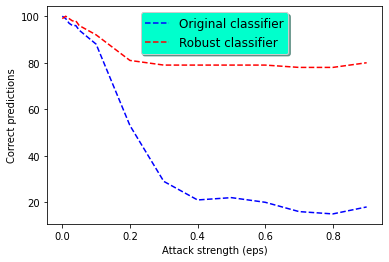

In [ ]:
#Plot the impact of adversarial training
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')
legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()

In [ ]:
?ZooAttack